In [1]:
import os
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '2'

import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers, optimizers

physical_devices = tf.config.list_physical_devices('GPU')
tf.config.experimental.set_memory_growth(physical_devices[0], True)

In [2]:
class CNN(layers.Layer):
    def __init__(self, units, kernel_size, strides, padding):
        super(CNN, self).__init__()
        self.cnn = layers.Conv2D(filters=units, kernel_size=kernel_size, strides=strides, padding=padding)
        self.bn = layers.BatchNormalization()
    
    def call(self, x, training=False):
        x = self.cnn(x)
        x = self.bn(x, training=training)
        x = tf.nn.relu(x)
        return x

In [3]:
class model64(keras.Model):
    def __init__(self):
        super(model64, self).__init__()
        self.layer1 = CNN(units=128, kernel_size=2, strides=1, padding='same')
        self.layer2 = layers.MaxPool2D(pool_size=(2, 2))
        self.layer3 = layers.Dropout(rate=0.3)
        self.layer4 = CNN(units=80, kernel_size=3, strides=1, padding='same')
        self.layer5 = layers.MaxPool2D(pool_size=(2, 2))
        self.layer6 = CNN(units=60, kernel_size=3, strides=1, padding='same')
        self.layer7 = layers.MaxPool2D(pool_size=(2, 2))
        self.layer8 = CNN(units=50, kernel_size=3, strides=1, padding='same')
        self.layer9 = layers.MaxPool2D(pool_size=(2, 2))
        self.flatten = layers.Flatten()
        self.layer10 = layers.Dense(units=512, activation='sigmoid')
        self.layer11 = layers.Dropout(rate=0.3)
        self.layer12 = layers.Dense(units=1, activation='sigmoid')
    
    def call(self, x, training=False):
        x = self.layer1(x, training=training)
        x = self.layer2(x)
        x = self.layer3(x)
        x = self.layer4(x, training=training)
        x = self.layer5(x)
        x = self.layer6(x, training=training)
        x = self.layer7(x)
        x = self.layer8(x, training=training)
        x = self.layer9(x)
        x = self.flatten(x)
        x = self.layer10(x)
        x = self.layer11(x)
        x = self.layer12(x)
        return x

    def model(self):
        x = keras.Input(shape=(64, 64, 3))
        return keras.Model(inputs=[x], outputs=[self.call(x)])

In [4]:
model = model64()
model.model().summary()

Metal device set to: Apple M1
Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 64, 64, 3)]       0         
                                                                 
 cnn (CNN)                   (None, 64, 64, 128)       2176      
                                                                 
 max_pooling2d (MaxPooling2D  (None, 32, 32, 128)      0         
 )                                                               
                                                                 
 dropout (Dropout)           (None, 32, 32, 128)       0         
                                                                 
 cnn_1 (CNN)                 (None, 32, 32, 80)        92560     
                                                                 
 max_pooling2d_1 (MaxPooling  (None, 16, 16, 80)       0         
 2D)                           

In [5]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator

train_datagen = ImageDataGenerator(
    rescale=1/255.,
    shear_range=0.3,
    horizontal_flip=True,
    vertical_flip=True,
    rotation_range=0.3,
    validation_split=0.1
)

test_datagen = ImageDataGenerator(
    rescale=1/255.
)

In [6]:
train_dataset = train_datagen.flow_from_directory(
    directory='../../training_image_augmented_output/',
    target_size=(64, 64),
    class_mode='binary',
    batch_size=32,
    subset='training'
)

val_dataset = train_datagen.flow_from_directory(
    directory='../../training_image_augmented_output/',
    target_size=(64, 64),
    class_mode='binary',
    batch_size=32,
    subset='validation'
)

test_dataset = test_datagen.flow_from_directory(
    directory='../../data/test/',
    target_size=(64, 64),
    class_mode='binary'
)

Found 9001 images belonging to 2 classes.
Found 999 images belonging to 2 classes.
Found 660 images belonging to 2 classes.


In [ ]:
model = model64()
model.compile(optimizer=tf.keras.optimizers.Adagrad(), loss='binary_crossentropy', 
             metrics=[
                 tf.keras.metrics.AUC(),
                 tf.keras.metrics.FalseNegatives(),
                 tf.keras.metrics.FalsePositives(),
                 tf.keras.metrics.Precision(),
                 tf.keras.metrics.Recall(),
                 'accuracy'
             ])
history = model.fit(train_dataset, 
                    epochs=100, 
                    validation_data=val_dataset, 
                    steps_per_epoch=len(train_dataset),
                    validation_steps=len(val_dataset))

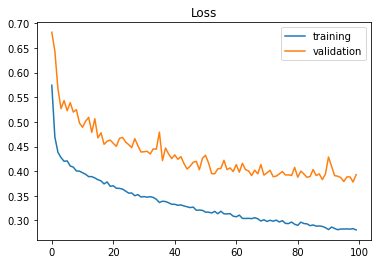

In [8]:
import matplotlib.pyplot as plt
plt.figure()
plt.plot(history.history['loss'], label='training')
plt.plot(history.history['val_loss'], label='validation')
plt.title('Loss')
plt.legend();

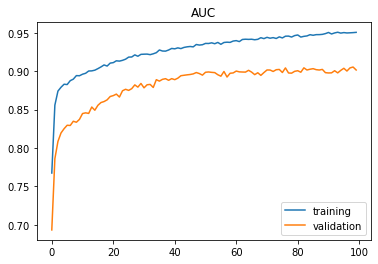

In [9]:
plt.figure()
plt.plot(history.history['auc'], label='training')
plt.plot(history.history['val_auc'], label='validation')
plt.title('AUC')
plt.legend();

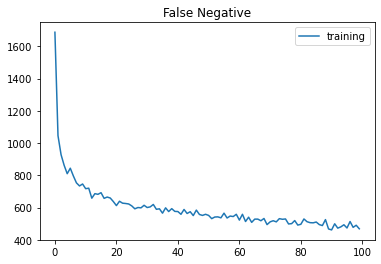

In [10]:
plt.figure()
plt.plot(history.history['false_negatives'], label='training')
plt.title('False Negative')
plt.legend();

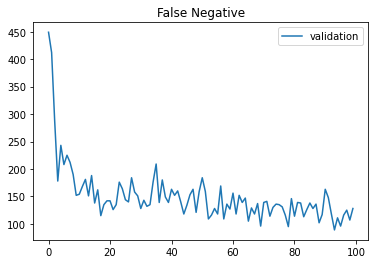

In [11]:
plt.figure()
plt.plot(history.history['val_false_negatives'], label='validation')
plt.title('False Negative')
plt.legend();

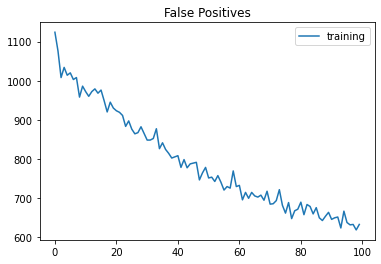

In [12]:
plt.figure()
plt.plot(history.history['false_positives'], label='training')
plt.title('False Positives')
plt.legend();

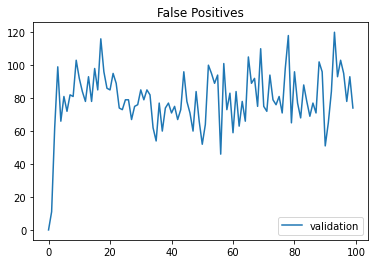

In [13]:
plt.figure()
plt.plot(history.history['val_false_positives'], label='validation')
plt.title('False Positives')
plt.legend();

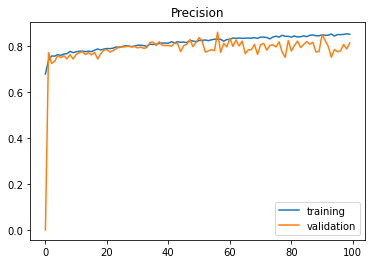

In [14]:
plt.figure()
plt.plot(history.history['precision'], label='training')
plt.plot(history.history['val_precision'], label='validation')
plt.title('Precision')
plt.legend();

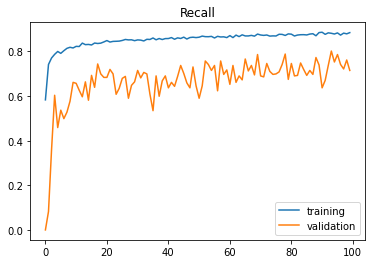

In [15]:
plt.figure()
plt.plot(history.history['recall'], label='training')
plt.plot(history.history['val_recall'], label='validation')
plt.title('Recall')
plt.legend();

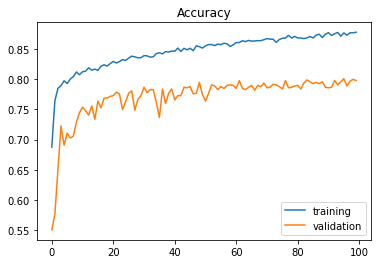

In [16]:
plt.figure()
plt.plot(history.history['accuracy'], label='training')
plt.plot(history.history['val_accuracy'], label='validation')
plt.title('Accuracy')
plt.legend();

In [17]:
model.evaluate(train_dataset)

282/282 [==============================] - 8s 28ms/step - loss: 0.3086 - auc: 0.9401 - false_negatives: 698.0000 - false_positives: 588.0000 - precision: 0.8507 - recall: 0.8276 - accuracy: 0.8571


[0.3086279034614563,
 0.9400833249092102,
 698.0,
 588.0,
 0.8506856560707092,
 0.8275691866874695,
 0.8571269512176514]

In [18]:
model.evaluate(val_dataset)

32/32 [==============================] - 1s 28ms/step - loss: 0.3954 - auc: 0.8995 - false_negatives: 131.0000 - false_positives: 80.0000 - precision: 0.7990 - recall: 0.7082 - accuracy: 0.7888


[0.39539089798927307,
 0.8995059728622437,
 131.0,
 80.0,
 0.7989949584007263,
 0.7082405686378479,
 0.7887887954711914]

In [19]:
model.evaluate(test_dataset)

21/21 [==============================] - 1s 49ms/step - loss: 0.3532 - auc: 0.9238 - false_negatives: 29.0000 - false_positives: 72.0000 - precision: 0.7901 - recall: 0.9033 - accuracy: 0.8470


[0.3531557321548462,
 0.9238147735595703,
 29.0,
 72.0,
 0.7900875210762024,
 0.9033333659172058,
 0.846969723701477]